In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
con_path = 'content.jpg'
style_path = 'style.jpg'

In [3]:
def load_preprocess_img(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    return vgg19.preprocess_input(img_arr)

In [4]:
content = load_preprocess_img(con_path)
style = load_preprocess_img(style_path)

In [5]:
vgg = vgg19.VGG19(weights='imagenet', include_top=False)

In [6]:
content_layer = 'block4_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [7]:
outputs = [vgg.get_layer(name).output for name in ([content_layer]+style_layers)]

In [8]:
model = Model([vgg.input], outputs)
model.trainable = False

In [9]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    vectorized = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(vectorized, vectorized, transpose_a=True)
    return gram/tf.cast(tf.shape(vectorized)[0], tf.float32)

In [10]:
def get_conten_and_style_rep(model, content_image, style_image):
    content_outputs = model(content_image)
    style_outputs = model(style_image)
    
    content_representation = content_outputs[0]
    style_representation = [gram_matrix(output) for output in style_outputs[1:]]
    return content_representation, style_representation

In [17]:
def compute_losses(model, generated_image, content_representation, style_representation, content_wt, style_wt):
    gen_outputs = model(generated_image)
    gen_content = gen_outputs[0]
    gen_styles = gen_outputs[1:]
    
    content_loss = tf.reduce_mean((gen_content - content_representation)**2)
    
    style_loss = 0
    for gen_style, style_target in zip(gen_styles, style_representation):
        style_loss+=tf.reduce_mean((gram_matrix(gen_style)-style_target)**2)
    
    style_loss/=len(style_representation)
    
    total_loss = content_wt *content_loss + style_wt *style_loss
    return total_loss

In [29]:
def style_transfer(content_img, style_img, model, iters= 1000, content_wt = 1e3, style_wt = 1e-2):
    conten_rep, style_rep = get_conten_and_style_rep(model, content_img, style_img)
    
    gen_img = tf.Variable(content_img, trainable=True)
    
    optimizer = Adam(learning_rate=5.0)
    
    for i in range(iters):
        with tf.GradientTape() as tape:
            loss = compute_losses(model, gen_img, conten_rep, style_rep, content_wt, style_wt)

        grads = tape.gradient(loss, gen_img)
        optimizer.apply_gradients([(grads, gen_img)])
        gen_img.assign(tf.clip_by_value(gen_img, -128.0, 127.0))
        
        if i%100 ==0 :
            print(f"Itenration {i}, Loss:{loss.numpy()}")
        
    return gen_img

In [30]:
def deprocess_image(img):
    img = img.numpy()
    img = img.reshape((224, 224, 3))
    img = img +[123.68, 116.779, 103.939]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [31]:
result_image = style_transfer(content, style, model)

Itenration 0, Loss:507232000.0
Itenration 100, Loss:172116000.0
Itenration 200, Loss:167704992.0
Itenration 300, Loss:167377088.0
Itenration 400, Loss:165041152.0
Itenration 500, Loss:166469120.0
Itenration 600, Loss:164021216.0
Itenration 700, Loss:164359488.0
Itenration 800, Loss:163844128.0
Itenration 900, Loss:163520528.0


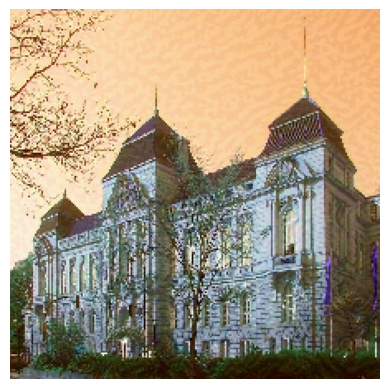

In [28]:
plt.imshow(deprocess_image(result_image))
plt.axis('off')
plt.show()